In [67]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
import tensorflow 
from tensorflow.keras.datasets import mnist
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pylab as plt
import cv2

(a) Preprocess Data

In [68]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() 
train_idx_0 = np.argwhere(Y_train==0)
train_idx_1 = np.argwhere(Y_train==1)
train_idx_2 = np.argwhere(Y_train==2)
train_idx_3 = np.argwhere(Y_train==3)
train_idx_4 = np.argwhere(Y_train==4)
train_idx_5 = np.argwhere(Y_train==5)
train_idx_6 = np.argwhere(Y_train==6)
train_idx_7 = np.argwhere(Y_train==7)
train_idx_8 = np.argwhere(Y_train==8)
train_idx_9 = np.argwhere(Y_train==9)

x_train = [] 


for i in range(1000):
  idx = train_idx_0[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_1[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_2[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_3[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_4[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_5[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())

for i in range(1000):
  idx = train_idx_6[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_7[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_8[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


for i in range(1000):
  idx = train_idx_9[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())


x_train = np.array(x_train)
idx_train=np.array(range(len(y_train)))
np.random.shuffle(idx_train)

x_tr = []
for i in range(len(idx_train)):
  x_tr.append(x_train[idx_train[i]].flatten())
x_tr = np.nan_to_num(np.array(x_tr)/np.sum(x_tr,axis=0)) 

pix_gr128_tr = x_tr > 128
pix_l128_tr = x_tr <= 128
idx_pix_gr128_tr = np.where(pix_gr128_tr== True)
idx_pix_l128_tr  = np.where(pix_l128_tr == True)
x_tr[idx_pix_gr128_tr] = 1.0
x_tr[idx_pix_l128_tr] = 0.0 
x_tr = torch.from_numpy(x_tr)
y_tr = torch.zeros(10000, 10)
train_data = TensorDataset(x_tr.float(),y_tr)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


**Problem 2**

(b) Train Model

In [69]:
class BernoulliVector():
    def __init__(self, logits):
        self.logits = logits

    def log_prob(self, x):
        pixelwise_log_probs = (
            x * (self.logits - nn.functional.softplus(self.logits))
            - (1 - x) * nn.functional.softplus(self.logits)
        )
        return pixelwise_log_probs.sum(1)
    
    def sample(self):
        samples = (
            torch.sigmoid(self.logits)
            >= torch.rand_like(self.logits))
        return samples

In [70]:
class MultivariateNormalDiag():
    def __init__(self, loc=None, scale=None):
        self.loc = loc
        self.scale = scale
        
    def log_prob(self, z):
        normalization_constant = (
            - self.scale.log()
            - 0.5 * np.log(2 * np.pi))
        square_term = -0.5 * ((z - self.loc) / self.scale) ** 2
        log_prob_vec = normalization_constant + square_term
        return log_prob_vec.sum(1)
        
    def sample(self):
        z = self.loc + self.scale * torch.randn_like(self.scale)
        return z

In [71]:
d, nh, D = 8, 128, 196

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.Tanh(),
    nn.Linear(nh, 2*d)) 

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.Tanh(),
    nn.Linear(nh, D)) 

In [77]:
def loss(x, encoder, decoder):
    # encoder
    q_loc_scale = encoder(x)
    qz_x = MultivariateNormalDiag(q_loc_scale[:, :d],
                                  nn.functional.softplus(q_loc_scale[:, d:]) + 1e-5)
    z_1 = qz_x.sample()
    z_2 = qz_x.sample()
    pz = MultivariateNormalDiag(torch.zeros_like(z_1), torch.ones_like(z_1))
    pz1_log = decoder(z_1)
    pz2_log = decoder(z_2)   
    px_z1 = BernoulliVector(pz1_log)
    px_z2 = BernoulliVector(pz2_log)
    comb_z1_z1 = torch.cat((px_z1.log_prob(x), px_z2.log_prob(x)), 0)
    comb_mean = comb_z1_z1.mean()      
    sample_1 = pz.log_prob(z_1) - qz_x.log_prob(z_1)
    sample_2 = pz.log_prob(z_2) - qz_x.log_prob(z_2) 
    comb_sample_mean = (torch.cat((sample_1, sample_2), 0)).mean()
    loss =  comb_mean+comb_sample_mean
    return loss, comb_mean, comb_sample_mean


In [83]:
from itertools import chain
def train_model(encoder, decoder, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    term1 = [] 
    term2 = [] 

    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss_value, term_1, term_2 = loss(batch, encoder, decoder)
            (-loss_value).backward()
            train_losses.append(loss_value.cpu().item())
            term1.append(term_1.cpu().item())
            term2.append(term_2.cpu().item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
            gd.zero_grad()
    return term1, term2  

Training the model of 16 epochs. 

In [85]:
term1, term2 = train_model(enc, dec, num_epochs=100)

Train loss: -0.010220290161669254 Batch 100 of 100           

(c) Plot two terms in loss. 

<Figure size 432x288 with 0 Axes>

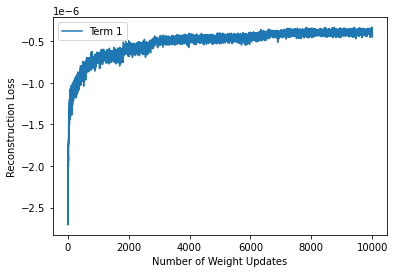

<Figure size 432x288 with 0 Axes>

In [87]:
import matplotlib.pyplot as plt

plt.plot(term1, label = 'Term 1')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.figure()